In [1]:
import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
import io
from scipy import stats
import arviz as az
from cmdstanpy import CmdStanModel
import seaborn as sns
import matplotlib.pyplot as plt

from config import FIRSTRATE_URL

sns.set_theme()
plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
def CalcReturns(prices: pd.Series, period=1) -> pd.Series:
    """
    Calculates log returns

    :param prices: series of prices
    :param period: period used to calculate returns. 1 means single period
    :returns: log returns
    """
    log_returns = np.log(prices) - np.log(prices.shift(period))
    return log_returns.dropna()


def CalcNegReturns(prices: pd.Series, period=1) -> pd.Series:
    """
    Calculates log returns and sets all positive returns to 0

    :param prices: series of prices
    :param period: period used to calculate returns. 1 means single period
    :returns: log returns with positive returns set to 0
    """
    log_returns = CalcReturns(prices, period)
    indicator = np.where(log_returns < 0, 1, 0)
    return indicator * log_returns


def CalcRV(prices: pd.Series) -> float:
    """
    Calculates daily realized variation

    pg.3:
    Barndorff-Nielsen, O. E. (2005).
    Econometrics of testing for jumps in financial economics using Bipower variation.
    Journal of Financial Econometrics, 4(1), 1–30. https://doi.org/10.1093/jjfinec/nbi022

    :param prices: series of prices from 1 trading day
    :returns: realized variation over that trading day
    """
    log_returns = CalcReturns(prices)
    return np.sum(log_returns ** 2)

In [12]:
# Download minute data for SPX and EOD for VIX
r = requests.get(FIRSTRATE_URL + "/9841", stream=True)
spx_file = ZipFile(io.BytesIO(r.raw.read()))
r = requests.get(
    "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv",
    stream=True,
)
vix_file = io.BytesIO(r.raw.read())

# Minute SPX data, and EOD VIX data
SPX = pd.read_csv(
    spx_file.open("SPX_1min.txt"),
    names=["date", "open", "high", "low", "close", "volume"],
    parse_dates=["date"],
).set_index("date")
vix = pd.read_csv(
    vix_file,
    header=0,
    names=["date", "open", "high", "low", "close"],
    parse_dates=["date"],
).set_index("date")["close"]

# 21 day rolling realized variation
RV = (
    SPX["close"]
    .groupby(lambda x: x.floor("d"))
    .agg(CalcRV)
)

# Daily negative returns only to capture leverage effect
neg_returns = CalcNegReturns(SPX["close"].groupby(lambda x: x.date).last(), period=21)

In [34]:
features = (
    pd.DataFrame()
    .assign(RV_lm=RV.rolling(21).sum().shift(21))
    .assign(RV1=RV.rolling(21).mean())
    .assign(RV3=RV.rolling(63).mean())
    .assign(RV6=RV.rolling(126).mean())
    .assign(RV12=RV.rolling(252).mean())
    .assign(RV_std=RV.rolling(21).std())
    .transform(np.log)
    .assign(negret_lm=neg_returns.shift(21))
    .assign(vix=vix)
    .dropna()
)

y = np.log(RV.rolling(21).sum().shift(-21).dropna())

common_index = features.index.intersection(y.index)
split = int(0.75 * len(common_index))
x_train = features.loc[common_index[:split]]
x_test = features.loc[common_index[split:]]
y_train = y.loc[common_index[:split]]
y_test = y.loc[common_index[split:]]

In [50]:
model_spec = """
data {
    int N;  // Length of data
    int M;  // Number of features
    vector[N] y;  // Forecast objective
    matrix[N, M] x;  // Features matrix
    
    int N_hat;  // Test set length
    vector[N_hat] y_hat;  // Test set forecast objective
    matrix[N_hat, M] x_hat;  // Test set features
}
parameters {
    real mu;
    vector[M] beta;
    real<lower=0> sigma;
}
model {
    mu ~ normal(0, 5);
    beta ~ normal(0, 1);
    sigma ~ normal(0, 5);
    
    y ~ normal(mu + x * beta, sigma);
}
generated quantities {
    real y_tilde[N_hat];  // Test set posterior predictive
    real pit[N_hat];  // Probability integral transform
    y_tilde = normal_rng(mu + x_hat * beta, sigma);
    for (t in 1:N_hat) {
        pit[t] = normal_cdf(y_hat[t] | mu + dot_product(x_hat[t], beta), sigma);
    }
}
"""

In [51]:
import os
os.chdir("/home/eadains/VolatilityTrading")

In [52]:
with open("./stan_model/RV_model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/RV_model.stan")
data = {
    "N": len(x_train),
    "M": len(x_train.columns),
    "y": y_train.values,
    "x": x_train.values,
    "N_hat": len(x_test),
    "y_hat": y_test.values,
    "x_hat": x_test.values
}
sample = model.sample(
    data=data, chains=4, parallel_chains=4, iter_warmup=250, iter_sampling=250
)


INFO:cmdstanpy:compiling stan file /home/eadains/VolatilityTrading/stan_model/RV_model.stan to exe file /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:compiled model executable: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [53]:
model_data = az.from_cmdstanpy(
    posterior=sample, observed_data={"y": y_test.values}, posterior_predictive="y_tilde"
)

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

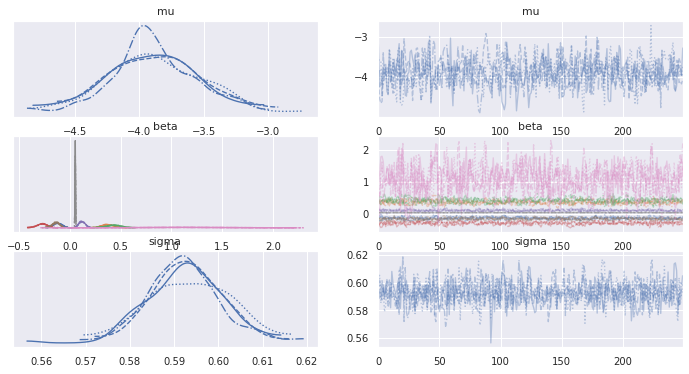

In [54]:
az.plot_trace(model_data, compact=True, var_names=["mu", "beta", "sigma"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

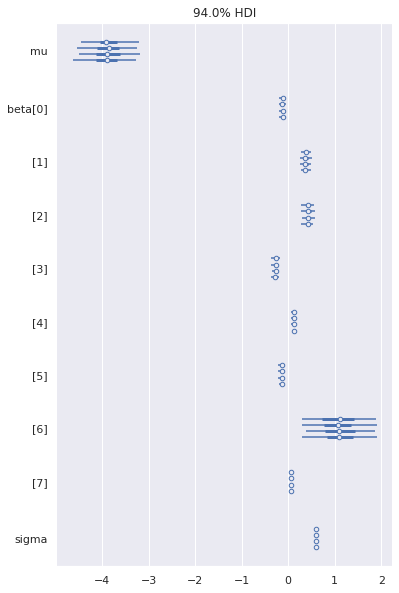

In [55]:
az.plot_forest(model_data, var_names=["mu", "beta", "sigma"])

Text(0.5, 1.0, 'Kurtosis')

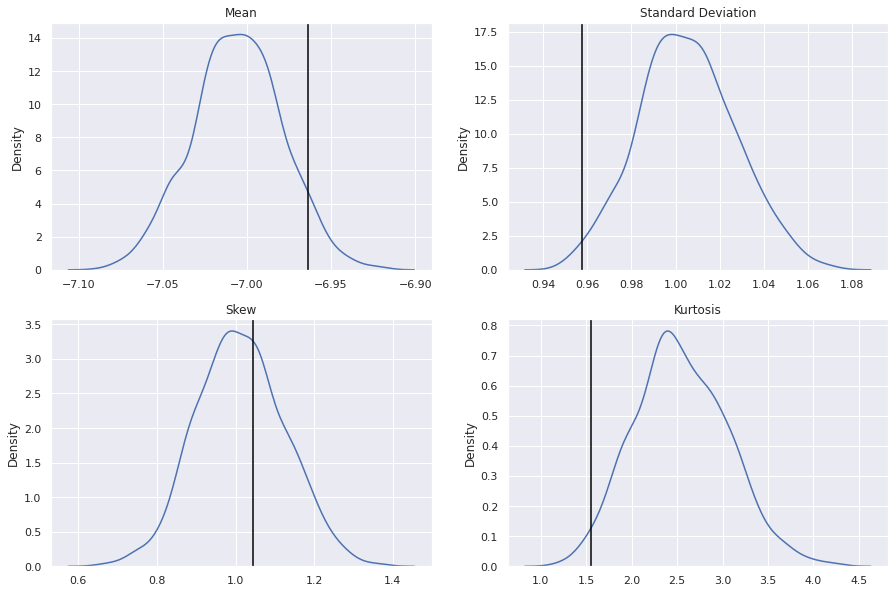

In [58]:
y_tilde = model_data.posterior_predictive.y_tilde.values.reshape(1000, -1)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

fig, axs = plt.subplots(2, 2)
sns.kdeplot(mean, ax=axs[0, 0])
axs[0, 0].axvline(np.mean(model_data.observed_data.y.values), color="black")
axs[0, 0].set_title("Mean")
sns.kdeplot(std, ax=axs[0, 1])
axs[0, 1].axvline(np.std(model_data.observed_data.y.values), color="black")
axs[0, 1].set_title("Standard Deviation")
sns.kdeplot(skew, ax=axs[1, 0])
axs[1, 0].axvline(stats.skew(model_data.observed_data.y.values), color="black")
axs[1, 0].set_title("Skew")
sns.kdeplot(kurt, ax=axs[1, 1])
axs[1, 1].axvline(stats.kurtosis(model_data.observed_data.y.values), color="black")
axs[1, 1].set_title("Kurtosis")

<AxesSubplot:ylabel='Density'>

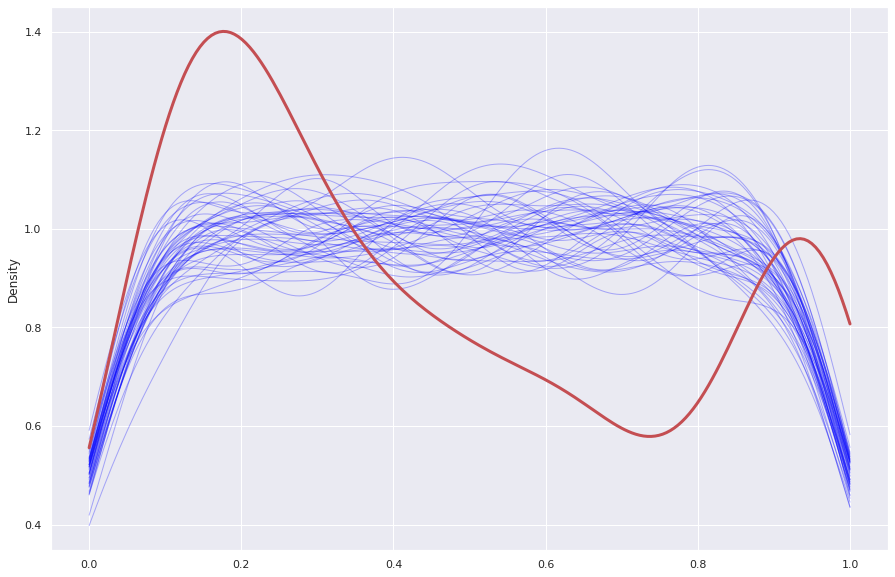

In [59]:
pit = np.mean(model_data.posterior.pit.values.reshape(1000, -1), axis=0)

for t in range(50):
    sns.kdeplot(stats.uniform(0, 1).rvs(1000), color="blue", linewidth=1, alpha=0.3, clip=(0, 1))
sns.kdeplot(pit, color="r", linewidth=3, clip=(0, 1))

In [60]:
stats.kstest(pit, "uniform")

KstestResult(statistic=0.09916296069570285, pvalue=8.018805648248443e-08)

In [62]:
regress = stats.linregress(np.mean(y_tilde, axis=0), model_data.observed_data.y.values)
print(f'Intercept: {regress.intercept} \nSlope: {regress.slope} \nR-Squared: {regress.rvalue**2}')

Intercept: -2.1148603372535986 
Slope: 0.6921077200286266 
R-Squared: 0.3440027644295313


In [63]:
stats.normaltest(y_test.values - np.mean(y_hat, axis=0))

NormaltestResult(statistic=233.95341875197715, pvalue=1.5763788769632817e-51)

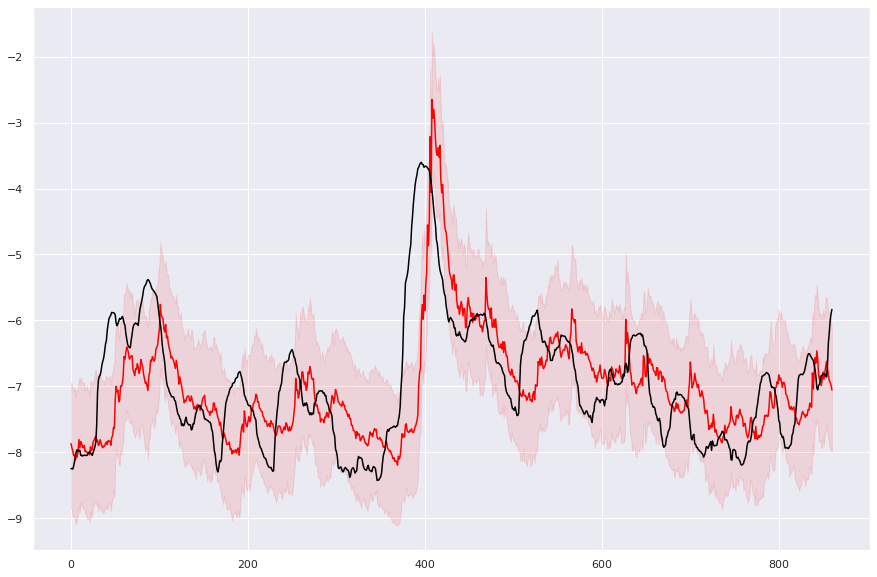

In [94]:
plt.plot(np.mean(y_tilde, axis=0), color="red")
plt.fill_between(np.arange(0, len(y_test)), np.percentile(y_tilde, 95, axis=0), np.percentile(y_tilde, 5, axis=0), color="red", alpha=0.1)
plt.plot(y_test.values, color="black")